# Проект рекомендательной системы по выявлению опасных дорожных участков

Данная система диагностики будет включать исследование имеющихся открытых данных по дорожно-транспортным происшествиям портала https://dtp-stat.ru

Данные представлены в формате `geojson` по всем регионам . Каждый файл имеет следующую структуру:
- "id": идентификатор
- "tags": показатели с официального сайта ГИБДД
- "light": время суток
- "point": координаты
- "nearby": ближайшие объекты
- "region": город/район
- "address": адрес
- "weather": погода
- "category": тип ДТП
- "datetime": дата и время
- "severity":тяжесть ДТП/вред здоровью
- "vehicles": участники – транспортные средства
    - "year": год производства транспортного средства
    - "brand": марка транспортного средства
    - "color": цвет транспортного средства
    - "model": модель транспортного средства
    - "category": категория транспортного средства
    - "participants": участники внутри транспортных средств
        - "role": роль участника
        - "gender": пол участника
        - "violations": нарушения правил участником
        - "health_status": состояние здоровья участника
        - "years_of_driving_experience": стаж вождения участника (только у водителей)
- "dead_count": кол-во погибших в ДТП
- "participants": участники без транспортных средств (описание, как у участников внутри транспортных средств)
- "injured_count": кол-во раненых в ДТП
- "parent_region": регион
- "road_conditions": состояние дорожного покрытия
- "participants_count": кол-во участников ДТП
- "participant_categories": категории участников

## Установка необходимых библиотек
Данный этап предназначен для того, чтобы установить на наше устройство те библиотеки, которые нельзя просто импортировать

In [1]:
#!pip install requests bs4 lxml
#!pip install notebook
#!pip install folium
#!pip install lightgbm
#!pip install phik

## Импорт необходимых библиотек, методов и метрик
После того, как мы установили все необходимые библиотеки, мы можем приступить к импорту того, что будем использовать для решения поставленной задачи на протяжении всего проекта

In [2]:
import requests
from bs4 import BeautifulSoup
import lxml
import pandas as pd
import numpy as np
import json
from random import randint
from tqdm.notebook import tqdm
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline

In [3]:
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(20,10)})

## Загрузка данных
Загрузку данных мы будем проводить с официального сайта ДТП России: `https://dtp-stat.ru/opendata/`. На данной странице нам предоставили 85 регионов, с которыми нам предстоит поработать. Для загрузки данных мы разработаем парсер, но первым делом давайте сохраним результат `html` страницы и потом преобразуем все методом `BeautifulSoup`:

In [4]:
url = f'https://dtp-stat.ru/opendata/'
req = requests.get(url)
result = req.content

soup = BeautifulSoup(result, 'lxml')

Все данные сохранены в объекте супа - пора приступить к поиску ссылок каждого региона. Сделаем это с помощью методов find_all (найдем все теги с определенным классом) и get (получим результат по переменной). Все ссылки, которые мы найдем мы вложим в список. Поиск кнопок будем осуществлять в цикле (не берем первый элемент, так как первая кнопка - "Поддержать проект"):

In [5]:
urls_list = []
for tag in soup.find_all('a', 'button')[1:]:
    urls_tail = tag.get('href')
    urls_list.append('https://dtp-stat.ru' + urls_tail)

После создания списка со всеми ссылками, мы можем начать загружать данные из ссылок и вводить их в единый датасет. Так как работа совершается на локальной машине с ограниченными мощностями, было решено взять не все данные, а лишь часть (5 регионов). Также стоит отметить, что последние три кнопки в списке ссылок - кнопки поддержать проект, карта ДТП в twitter и карта ДТП в telegram:

In [6]:
total_data = pd.DataFrame()
for url in tqdm(urls_list[:-83]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data = pd.concat([total_data, last_data])

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
total_data.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,[Сухое],2,[Все участники]
1,2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,"{'lat': 53.369248, 'long': 83.699802}","[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,[Мокрое],3,"[Дети, Все участники]"
2,2565463,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,"{'lat': 53.343391, 'long': 83.704684}","[Многоквартирные жилые дома, Школа либо иная д...",Барнаул,740,"г Барнаул, тракт Павловский, 68",[Ясно],Наезд на пешехода,2021-04-20 18:55:00,Легкий,"[{'year': 1988, 'brand': 'TOYOTA', 'color': 'Б...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,"[Дети, Пешеходы, Все участники]"
3,2565477,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 53.380807, 'long': 83.690007}","[Жилые дома индивидуальной застройки, Нерегули...",Барнаул,820,"г Барнаул, ул Совхозная, 10 а",[Пасмурно],Наезд на пешехода,2021-04-28 12:20:00,Легкий,"[{'year': 2011, 'brand': 'FIAT', 'color': 'Бел...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",1,Алтайский край,[Сухое],2,"[Пешеходы, Все участники]"
4,2565484,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 53.351736, 'long': 83.718964}","[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,770,"г Барнаул, ул Советской Армии, 123",[Дождь],Наезд на пешехода,2021-04-27 21:00:00,Тяжёлый,"[{'year': 2002, 'brand': 'HONDA', 'color': 'Че...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,"[Мокрое, Отсутствие, плохая различимость гориз...",2,"[Пешеходы, Все участники]"


Данные в таблицу прогружены и мы видим некоторые недочеты:
- словари в некоторых столбцах: point, vehicles
- списки в некоторых столбцах: tags, nearby, weather, vehicles, participants, road_conditions, participant_categories
- неопознанный столбец scheme

После просмотра первых строк датасета, мы приступаем к проверке типов столбцов и количеству пропусков в них:

In [8]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55876 entries, 0 to 8778
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      55876 non-null  int64 
 1   tags                    55876 non-null  object
 2   light                   55876 non-null  object
 3   point                   55876 non-null  object
 4   nearby                  55876 non-null  object
 5   region                  55876 non-null  object
 6   scheme                  52093 non-null  object
 7   address                 53579 non-null  object
 8   weather                 55876 non-null  object
 9   category                55876 non-null  object
 10  datetime                55876 non-null  object
 11  severity                55876 non-null  object
 12  vehicles                55876 non-null  object
 13  dead_count              55876 non-null  int64 
 14  participants            55876 non-null  object
 15  inj

Неверные типы данных замечены в:
- datetime

Пропуски в данных замечены в:
- scheme
- address

Исходя из того, что мы имеем, можно приступить к предобработке данных

## Предобработка данных

In [9]:
# def uniting_datasets(data_main, data_second, dropping_col):
#     return pd.concat([data_main, data_second], axis=1).drop(dropping_col, axis=1)

def take_from_list_dict(data, where_to_get, except_value):
    values_list = []
    for row in tqdm(range(data.shape[0])):
        try: 
            values_list.append(list(where_to_get)[row].values())
        except:
            values_list.append(except_value)
    return values_list

Так как у нас много столбцов с данными, которые находятся в виде списка, то можно создать функцию, которая преобразует все в нормальный вид, а если там пустые скобки, то вернет текст - "Нету информации":

In [10]:
def take_info_from_list(val_list):
    val_str = ', '
    if len(val_list) == 0:
        return 'Нету информации'
    else:
        return val_str.join(val_list)

Применим функцию ко всем столбцам со скобками:

In [11]:
total_data['tags'] = total_data['tags'].apply(take_info_from_list)
total_data['nearby'] = total_data['nearby'].apply(take_info_from_list)
total_data['weather'] = total_data['weather'].apply(take_info_from_list)
total_data['road_conditions'] = total_data['road_conditions'].apply(take_info_from_list)
total_data['participant_categories'] = total_data['participant_categories'].apply(take_info_from_list)
#total_data['participants'] = total_data['participants'].apply(take_info_from_list)

In [12]:
total_data.head(2)

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","Многоквартирные жилые дома, Административные з...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,Сухое,2,Все участники
1,2489516,"Дорожно-транспортные происшествия, ДТП и постр...",Светлое время суток,"{'lat': 53.369248, 'long': 83.699802}","Многоквартирные жилые дома, Нерегулируемый пеш...",Барнаул,300,"г Барнаул, ул Юрина, 241",Дождь,Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,Мокрое,3,"Дети, Все участники"


Как можно заметить, все скобки расскрыты и приведены в нормальный вид.

Следующий шаг - вытащить данные из столбца `point` и сохранить в нашу таблицу как значения столбцов, которые равны ключам словаря, хранящийся там. Для этого создадим отдельный список, который будет хранить все значения данного столбца. Если мы найдем пропуски в данных, то мы их заполним `NaN`:

In [13]:
total_data.reset_index(drop=True, inplace=True)

In [14]:
except_value = [np.nan, np.nan]
values_data = []
for row in tqdm(range(total_data.shape[0])):
    try: 
        values_data.append(list(total_data['point'])[row].values())
    except:
        values_data.append(except_value)

data_points = pd.DataFrame(columns=list(total_data['point'])[0].keys(), data=values_data)

data_points.head(1)



  0%|          | 0/55876 [00:00<?, ?it/s]

,lat,long
0,53.342,83.6903


In [15]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55876 entries, 0 to 55875
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      55876 non-null  int64 
 1   tags                    55876 non-null  object
 2   light                   55876 non-null  object
 3   point                   55876 non-null  object
 4   nearby                  55876 non-null  object
 5   region                  55876 non-null  object
 6   scheme                  52093 non-null  object
 7   address                 53579 non-null  object
 8   weather                 55876 non-null  object
 9   category                55876 non-null  object
 10  datetime                55876 non-null  object
 11  severity                55876 non-null  object
 12  vehicles                55876 non-null  object
 13  dead_count              55876 non-null  int64 
 14  participants            55876 non-null  object
 15  in

In [16]:
total_data_ready = pd.concat([total_data, data_points], axis=1)
total_data_ready.head(2)

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","Многоквартирные жилые дома, Административные з...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,Сухое,2,Все участники,53.342000,83.690300
1,2489516,"Дорожно-транспортные происшествия, ДТП и постр...",Светлое время суток,"{'lat': 53.369248, 'long': 83.699802}","Многоквартирные жилые дома, Нерегулируемый пеш...",Барнаул,300,"г Барнаул, ул Юрина, 241",Дождь,Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,Мокрое,3,"Дети, Все участники",53.369248,83.699802


Таблица преобразована, новые столбцы для широты и долготы готовы. Далее можно заняться датой и заполнением пропуска в столбце `address`, пропуски которого мы будем заполнять словом "Неизвестно":

In [17]:
total_data_ready['datetime'] = pd.to_datetime(total_data_ready['datetime'], format='%Y-%m-%d')

In [18]:
total_data_ready['address'] = total_data_ready['address'].fillna('Неизвестно')

Преобразования совершены, теперь нужно удалить те столбцы, с которыми мы не будем работать: `scheme`, `point`, `vehicles`, `participants`. Почему именно с ними? Потому что столбец `scheme` неопознан, его нет в описании к признакам; `point` - данный признак мы расскрыли и теперь его просто удаляем; `vehicles` - информация в данном столбце никак не поможет нам решить задачу; `participants` - данная информация также не поможет нам в решении задачи.

In [19]:
total_data_ready = total_data_ready.drop(['scheme', 'point', 'vehicles', 'participants'], axis=1)
total_data_ready
total_data_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55876 entries, 0 to 55875
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      55876 non-null  int64         
 1   tags                    55876 non-null  object        
 2   light                   55876 non-null  object        
 3   nearby                  55876 non-null  object        
 4   region                  55876 non-null  object        
 5   address                 55876 non-null  object        
 6   weather                 55876 non-null  object        
 7   category                55876 non-null  object        
 8   datetime                55876 non-null  datetime64[ns]
 9   severity                55876 non-null  object        
 10  dead_count              55876 non-null  int64         
 11  injured_count           55876 non-null  int64         
 12  parent_region           55876 non-null  object

Следующий этап в предобработке - поиск повторяющихся значений. Для этого воспользуемся методом `value_counts` по столбцу `id`:

In [20]:
total_data_ready['id'].value_counts(ascending=False).head(3)

2311491    1
2219565    1
2219400    1
Name: id, dtype: int64

В результате видим, что повторяющихся значений у нас не обнаружено, что радует.

## Создание новых признаков

In [21]:
uniq_region = total_data_ready['region'].unique()
uniq_region

array(['Барнаул', 'Немецкий национальный район', 'Шипуновский район',
       'Чарышский район', 'Целинный район', 'Хабарский район',
       'Усть-Пристанский район', 'Усть-Калманский район',
       'Угловский район', 'Тюменцевский район', 'Троицкий район',
       'Третьсяковский район', 'Топчихинский район', 'Тогульский район',
       'Тальменский район', 'Табунский район', 'Шелаболихинский район',
       'Солтонский район', 'Солонешенский район', 'Советский район',
       'Суетский район', 'Славгородский район', 'Романовский район',
       'Родинский район', 'Ребрихинский район', 'Поспелихинский район',
       'Петропавловский район', 'Панкрушихинский район',
       'Павловский район', 'Зональный район', 'Новичихинский район',
       'Михайловский район', 'Мамонтовский район', 'Локтевский район',
       'Кытмановский район', 'Курьинский район', 'Кулундинский район',
       'Крутихинский район', 'Краснощековский район',
       'Красногорский район', 'Косихинский район', 'Ключевский рай

Для работы с нашими данными мы создадим признаки, которые помогут решить поставленню задачу: `danger_level` - уровень опасности адреса, который составляется при помощи формулы, использующую сложности ДТП, количество инцидентов по региону и инцедентов по адресу; `total_incidents_region` - количество инцидентов по региону; `total_incidents_address` - количество инцидентов по адресу; `severity_num` - сложность ДТП в цифрах, `month` - месяц, в который произошло ДТП.

Ниже приведены функции, которые создадут нам описанные выше признаки:

In [22]:
def total_incidents_on_region(row):
    region = row['region']
    return total_data_ready[total_data_ready['region'] == region]['id'].count()

def total_incidents_on_address(row):
    region = row['region']
    address = row['address']
    return total_data_ready[(total_data_ready['address'] == address) & (total_data_ready['region'] == region)]['id'].count()

def severity_to_number(value):
    if value == 'Легкий':
        return 3
    elif value == 'Тяжёлый':
        return 2
    else:
        return 1

def danger_level_value(row):
    severity_num = row['severity_num']
    total_incidents_region = row['total_incidents_region']
    total_incidents_address = row['total_incidents_address']
    dead_count = row['dead_count']
    injured_count = row['injured_count']
    participants_count = row['participants_count']
    
    danger_level = (2**(abs(severity_num-3)) * (total_incidents_address/total_incidents_region))/total_incidents_region
    return danger_level

Функции созданы, значит мы можем приступить к их использованию - добавим признаки в нашу таблицу (ремарка - мы создаем дополнительные два столбца: `frequency` и `month`, так как они также могут нам помочь в дальнейшем прогнозе):

In [23]:
total_data_ready['total_incidents_region'] = total_data_ready.apply(total_incidents_on_region, axis=1)
total_data_ready['total_incidents_address'] = total_data_ready.apply(total_incidents_on_address, axis=1)
total_data_ready['severity_num'] = total_data_ready['severity'].apply(severity_to_number)
total_data_ready['danger_level'] = total_data_ready.apply(danger_level_value, axis=1)
total_data_ready['frequency'] = total_data_ready['total_incidents_address']/total_data_ready['total_incidents_region']
total_data_ready['month'] = total_data_ready.datetime.dt.month
total_data_ready.head()

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,Сухое,2,Все участники,53.342000,83.690300,8823,1,3,1.284599e-08,0.000113,9
1,2489516,"Дорожно-транспортные происшествия, ДТП и постр...",Светлое время суток,"Многоквартирные жилые дома, Нерегулируемый пеш...",Барнаул,"г Барнаул, ул Юрина, 241",Дождь,Столкновение,2020-09-24 09:30:00,Легкий,0,2,Алтайский край,Мокрое,3,"Дети, Все участники",53.369248,83.699802,8823,2,3,2.569197e-08,0.000227,9
2,2565463,"Дорожно-транспортные происшествия, ДТП и постр...",Светлое время суток,"Многоквартирные жилые дома, Школа либо иная де...",Барнаул,"г Барнаул, тракт Павловский, 68",Ясно,Наезд на пешехода,2021-04-20 18:55:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",2,"Дети, Пешеходы, Все участники",53.343391,83.704684,8823,1,3,1.284599e-08,0.000113,4
3,2565477,Дорожно-транспортные происшествия,Светлое время суток,"Жилые дома индивидуальной застройки, Нерегулир...",Барнаул,"г Барнаул, ул Совхозная, 10 а",Пасмурно,Наезд на пешехода,2021-04-28 12:20:00,Легкий,0,1,Алтайский край,Сухое,2,"Пешеходы, Все участники",53.380807,83.690007,8823,1,3,1.284599e-08,0.000113,4
4,2565484,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Советской Армии, 123",Дождь,Наезд на пешехода,2021-04-27 21:00:00,Тяжёлый,0,1,Алтайский край,"Мокрое, Отсутствие, плохая различимость горизо...",2,"Пешеходы, Все участники",53.351736,83.718964,8823,2,2,5.138394e-08,0.000227,4


Все признаки созданы, таблица наполнилась новыми столбцами, которые помогут нам в прогнозе опасности дорог. Однако давайте проверим наш главный признак - `danger_level`. Необходимость его проверки заключается в том, что данный признак создавался с применением математической функции, которую мы сами составили, поэтому нужно убедиться в рациональности значений:

In [24]:
total_data_ready.danger_level.describe()

count    5.587600e+04
mean     1.293008e-04
std      8.511447e-03
min      1.284599e-08
25%      2.050624e-07
50%      2.420484e-06
75%      3.399944e-05
max      2.000000e+00
Name: danger_level, dtype: float64

В глаза бросатеся максимальное значение - 2. Остальные данные лежат в приемлемых границах - каждая 25% данных разнится от соседей умножением на 10, но максимальное значение в сравнении с другими похоже на выброс. Скорее всего это связано с тем, что (согласно нашей формуле составления `danger_level`) частота ДТП на выбранной улице огромная, а общее количество ДТП по региону низкое. Давайте проверим данное рассуждение просмотром строки максимального уровня опасности:

In [25]:
total_data_ready[total_data_ready['danger_level'] == total_data_ready['danger_level'].max()]

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month
31603,2221936,Дорожно-транспортные происшествия,Светлое время суток,Нету информации,Новая Земля,"Прочие автомобильные дороги (ведомственные), 1 км",Пасмурно,Опрокидывание,2017-07-23 17:30:00,Тяжёлый,0,1,Архангельская область,Мокрое,2,Все участники,71.5572,52.3364,1,1,2,2.0,1.0,7


Количество ДТП по региону равно 1, количество ДТП по адресу также равно 1, а тяжесть ДТП равна 2, то есть тяжелое ДТП. Именно благодаря таким данным и получился выброс в виде 2. Нам такое значение не нужно по причине вреда на остальные данные при составлении и обучении моделей, поэтому мы просто уберем данную строку из таблицы:

In [26]:
total_data_ready = total_data_ready.query('danger_level != 2')

Признаки созданы, можем приступать к визуализации данных


## Визуализация данных

В этапе визуализации данных мы рассмотрим как распределяются данные, посмотрим какая погода была при различных типах ДТП, какие группы людей участвовали в ДТП и взглянем на распределение количества ранненых и общего числа постродавших во время ДТП. Также мы взглянем на зависимость признака `severity` к `danger_level`, в какие месяцы уровень опасности улиц был наибольшим и зависимость признака `severity` к `total_incidents_address`:

Первый график - количество раненных в ДТП к типу ДТП:

<AxesSubplot:xlabel='severity', ylabel='injured_count'>

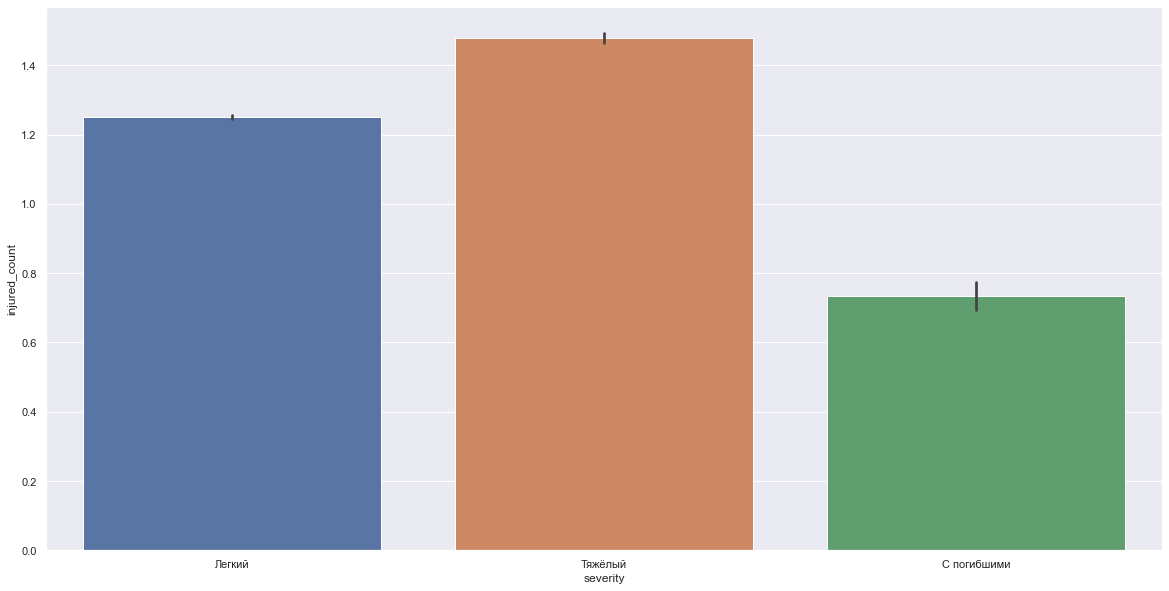

In [27]:
sns.barplot(x='severity', y='injured_count', data=total_data_ready)

По графику можно заметить, что количество раненных больше всего было во время тяжелых случаев ДТП, потом в легких и в последнюю часть - с погибшими. Все логично, ведь во-первых, случаев с погибшими гораздо меньше по сравнению с остальными, во-вторых, во время таких ДТП люди чаще умирают, чем остаются раненными. Исходя их всего этого, тяжелые случаи ДТП содержат больше всего раненных людей, чем остальные

Следующий график - общее число участников ДТП к типу ДТП:

<AxesSubplot:xlabel='severity', ylabel='participants_count'>

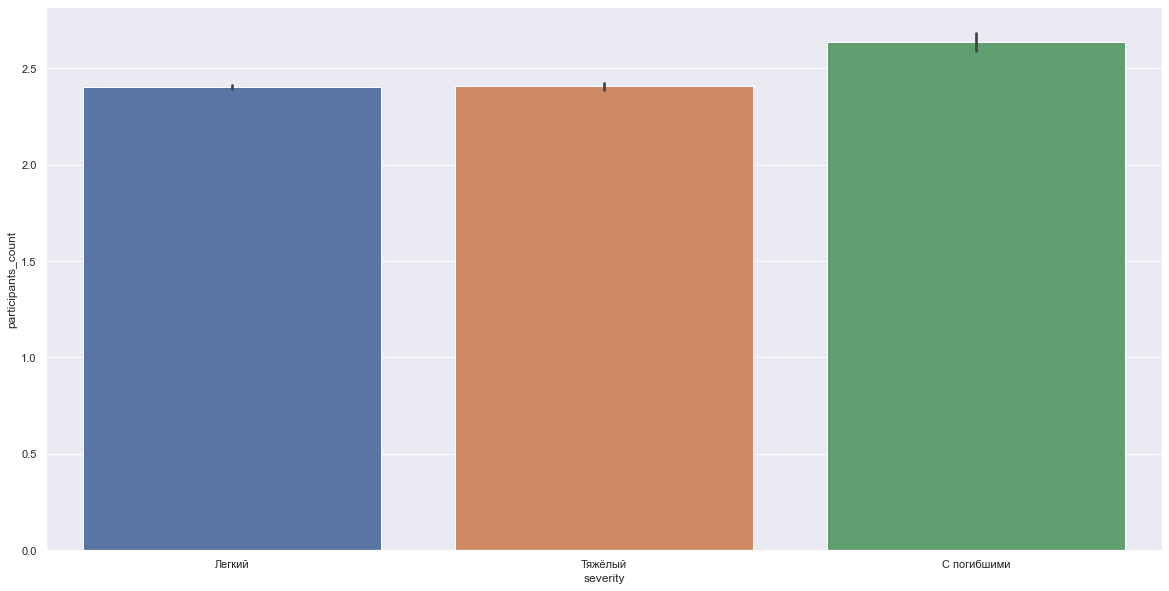

In [28]:
sns.barplot(x='severity', y='participants_count', data=total_data_ready)

График выше показывает нам, что в случаях со смертельными исходами участвовало больше участников, чем в остальных. Все верно, ведь легкое ДТП чаще происходит с меньшим количеством участников (поэтому его и называют легким). Тяжелые случаи (без смертей) происходят с большим количеством раненных (как было показано в прошлом графике), но с таким же количество участников ДТП. А вот если происходят смертельные случаи, то это влечет за собой либо слишком большое количество участников и некоторые смерти, либо малое количество участников, но выше количества смертей.    

Далее пойдут сводные таблицы, которые покажут численную разницу в количестве раненных к тяжести ДТП, уровню освещения и погоде:

In [29]:
weather_to_injured = pd.pivot_table(total_data_ready, values='injured_count', index=['severity', 'light']
                                    , columns='weather'
                                    , aggfunc='sum')
weather_to_injured = weather_to_injured.fillna(0)
weather_to_injured

weather                                                  Дождь  \
severity    light                                                
Легкий      В темное время суток, освещение включено     437.0   
            В темное время суток, освещение не включено   22.0   
            В темное время суток, освещение отсутствует  182.0   
            Не установлено                                 0.0   
            Светлое время суток                          833.0   
            Сумерки                                       57.0   
С погибшими В темное время суток, освещение включено      30.0   
            В темное время суток, освещение не включено    1.0   
            В темное время суток, освещение отсутствует   30.0   
            Не установлено                                 0.0   
            Светлое время суток                          116.0   
            Сумерки                                        1.0   
Тяжёлый     В темное время суток, освещение включено     288.0   
            В темное время суток, освещение не включено   22.0   
            В темное время суток, освещение отсутствует  181.0   
            Светлое время суток                          443.0   
            Сумерки                                       45.0   

weather                                                  Дождь, Снегопад  \
severity    light                                                          
Легкий      В темное время суток, освещение включено                 4.0   
            В темное время суток, освещение не включено              0.0   
            В темное время суток, освещение отсутствует             11.0   
            Не установлено                                           0.0   
            Светлое время суток                                      6.0   
            Сумерки                                                  2.0   
С погибшими В темное время суток, освещение включено                 0.0   
            В темное время суток, освещение не включено              0.0   
            В темное время суток, освещение отсутствует              0.0   
            Не установлено                                           0.0   
            Светлое время суток                                      0.0   
            Сумерки                                                  0.0   
Тяжёлый     В темное время суток, освещение включено                 4.0   
            В темное время суток, освещение не включено              0.0   
            В темное время суток, освещение отсутствует              1.0   
            Светлое время суток                                      3.0   
            Сумерки                                                  2.0   

weather                                                  Дождь, Температура ниже -30С  \
severity    light                                                                       
Легкий      В темное время суток, освещение включено                              0.0   
            В темное время суток, освещение не включено                           0.0   
            В темное время суток, освещение отсутствует                           0.0   
            Не установлено                                                        0.0   
            Светлое время суток                                                   0.0   
            Сумерки                                                               0.0   
С погибшими В темное время суток, освещение включено                              0.0   
            В темное время суток, освещение не включено                           0.0   
            В темное время суток, освещение отсутствует                           0.0   
            Не установлено                                                        0.0   
            Светлое время суток                                                   0.0   
            Сумерки                                                               0.0   
Тяжёлый     В темное время суток, освещение включено  

По таблице видно, что большее количество всех аварий происходило в ясную погоду в светлое время суток, поменьше в пасмурную погоду и еще меньше в дождливую погоду. Все логично, ведь ясная погода случается чаще всего, а это значит и больше времени для ДТП. Это означает, что, зачастую, на количество ДТП мало влияют посторонние факторы, такие как гололед.

In [30]:
category_to_injured = pd.pivot_table(total_data_ready, values='injured_count', index='severity'
                                    , columns='category'
                                    , aggfunc='sum')
category_to_injured = category_to_injured.fillna(0)
category_to_injured

category,"Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.",Иной вид ДТП,Наезд на велосипедиста,Наезд на внезапно возникшее препятствие,Наезд на гужевой транспорт,Наезд на животное,"Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность","Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы","Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ",Наезд на пешехода,Наезд на препятствие,Наезд на стоящее ТС,Опрокидывание,Отбрасывание предмета,Падение груза,Падение пассажира,Столкновение,Съезд с дороги
severity,,,,,,,,,,,,,,,,,,
Легкий,2.0,205.0,1201.0,3.0,8.0,70.0,16.0,26.0,40.0,10398.0,2031.0,1128.0,2827.0,35.0,10.0,1807.0,20596.0,2057.0
С погибшими,0.0,7.0,15.0,0.0,1.0,6.0,0.0,0.0,1.0,142.0,248.0,106.0,502.0,0.0,0.0,0.0,2185.0,197.0
Тяжёлый,0.0,108.0,584.0,0.0,20.0,48.0,2.0,0.0,3.0,6170.0,1972.0,662.0,2897.0,9.0,0.0,304.0,10890.0,1894.0


По таблице видим, что чаще всего ДТП происходят при столкновении машин, наезде на пешехода и опрокидывании. Все эти признаки говорят о том, что либо виноваты водители, либо виноваты внешние факторы. Однако в прошлой таблице мы заметили влияние внешних факторов на количество ДТП и поняли - погода на ДТП влияет не сильно, что говорит о виновности самих водителей в ДТП.

Следующий график покажет нам, насколько сильна зависимость признака `severity` к `danger_level`:

<AxesSubplot:xlabel='severity', ylabel='danger_level'>

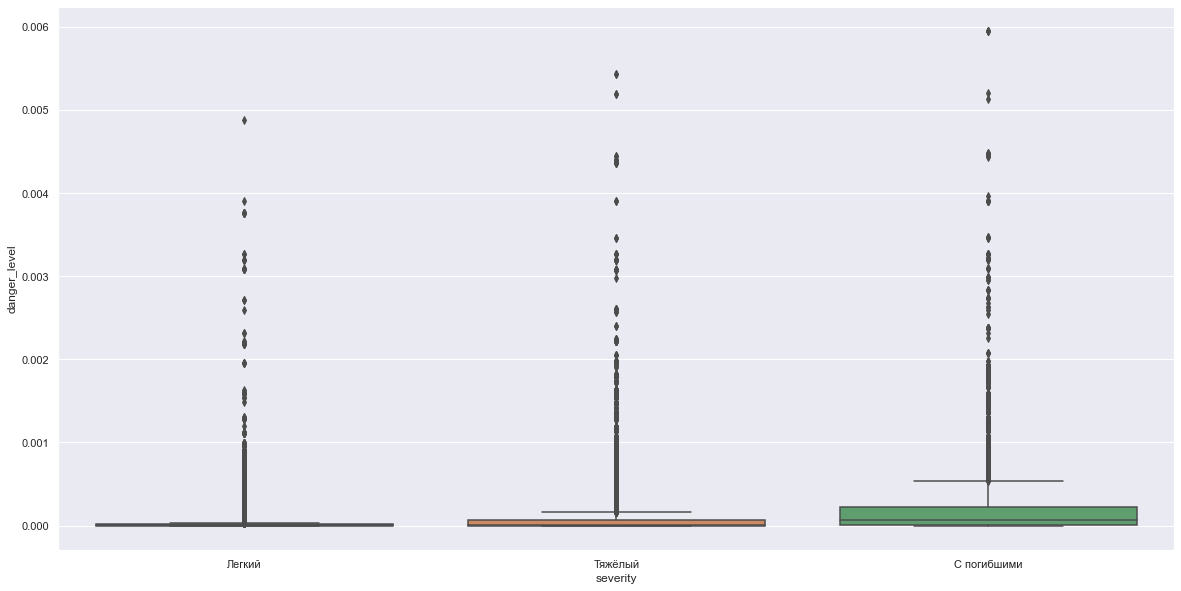

In [31]:
sns.boxplot(x="severity", y="danger_level", data=total_data_ready[total_data_ready['danger_level'] < 0.006])

Все как и ожидалось - чем выше тяжесть ДТП, тем выше уровень опасности дороги. Далее на очереди график с анализом самого опасного месяца. Зависимость следующая: признак `month` к признаку `danger_level`:

<AxesSubplot:xlabel='month', ylabel='danger_level'>

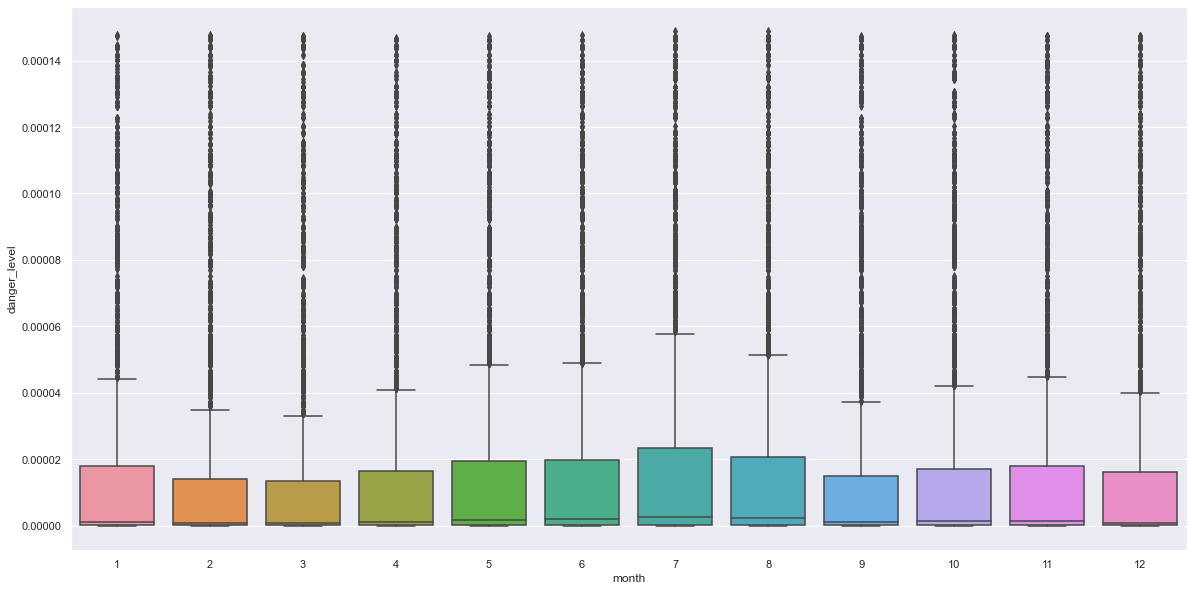

In [32]:
sns.boxplot(x="month", y="danger_level", data=total_data_ready[total_data_ready['danger_level'] < 0.00015])

Самым опасным месяцем оказался июль, второй - август и завершает тройку июнь. Это полностью соответсвуют погоде, которая происходила чаще всего во время ДТП - ясная. Это еще раз доказывает нам, что чаще всего в ДТП виноваты обычные водители. 

Теперь посмотрим, какая тяжесть ДТП происходила чаще по адресам:

<AxesSubplot:xlabel='severity', ylabel='total_incidents_address'>

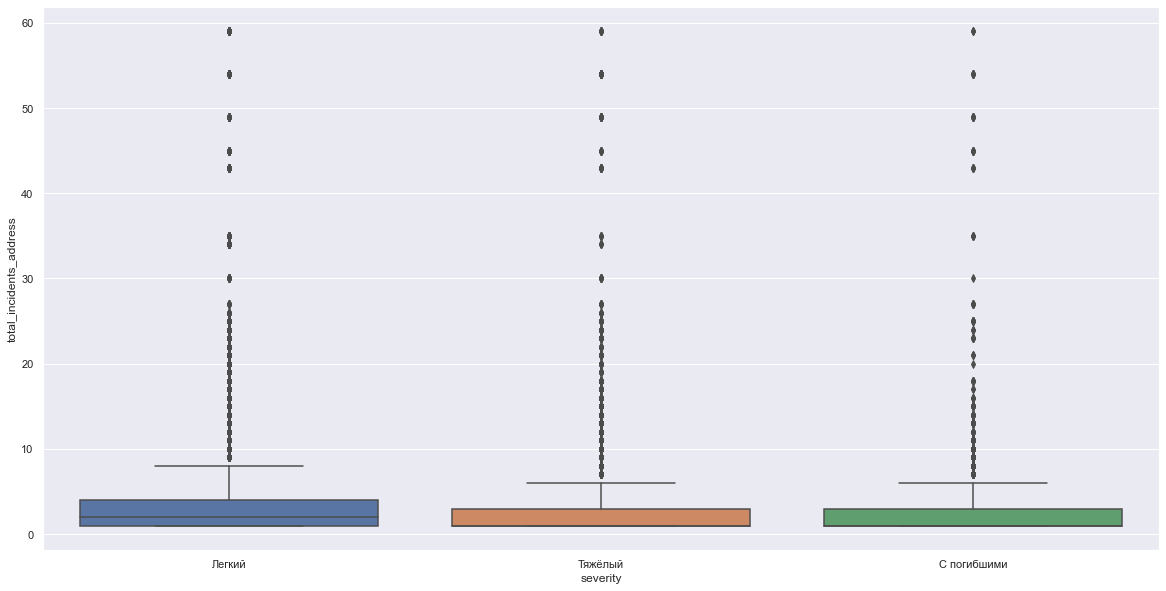

In [33]:
sns.boxplot(x="severity", y="total_incidents_address", data=total_data_ready[total_data_ready['total_incidents_address'] < 80])

Опять же, все логично - чаще всего на количество ДТП по определенным адресам происходит ДТП легкой тяжести, остальные с одинаковой частотой. Также мы убрали сильные выбросы с данных

Этап визуализации завершен, а значит мы можем сделать некие выводы:
- Количество раненных в ДТП больше всего в тяжелом ДТП;
- ДТП чаще всего происходят в ясную погоду;
- Самые опасные месяцы: июль, август и июнь - 3 месяца лета.

## Выделение данных для кластеризации 

Следующим этапом в нашей работе будет подготовка к кластеризации. Кластеризация - процесс разбиения данных на кластеры (классы), данные которых объединяются по каким-то схожим признакам. Позволяет перейти от обучения без учителя к обучению с учителем (мы создадим целевой признак). 

Для того чтобы начать кластеризацию, мы возьмем наиболее важные признаки для составления классов уровня опасности дороги. Однако первым делом мы приведем категориальные признаки в числовой вид, чтобы использовать их в будущем:

In [34]:
cat_col = ['light','weather','category','road_conditions','participant_categories']
encoder = LabelEncoder()

total_data_ready[cat_col] = total_data_ready[cat_col].apply(encoder.fit_transform)
total_data_ready.head()

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month
0,2311491,Дорожно-транспортные происшествия,2,"Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",21,10,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,938,2,5,53.342000,83.690300,8823,1,3,1.284599e-08,0.000113,9
1,2489516,"Дорожно-транспортные происшествия, ДТП и постр...",4,"Многоквартирные жилые дома, Нерегулируемый пеш...",Барнаул,"г Барнаул, ул Юрина, 241",0,16,2020-09-24 09:30:00,Легкий,0,2,Алтайский край,104,3,14,53.369248,83.699802,8823,2,3,2.569197e-08,0.000227,9
2,2565463,"Дорожно-транспортные происшествия, ДТП и постр...",4,"Многоквартирные жилые дома, Школа либо иная де...",Барнаул,"г Барнаул, тракт Павловский, 68",21,9,2021-04-20 18:55:00,Легкий,0,1,Алтайский край,1175,2,18,53.343391,83.704684,8823,1,3,1.284599e-08,0.000113,4
3,2565477,Дорожно-транспортные происшествия,4,"Жилые дома индивидуальной застройки, Нерегулир...",Барнаул,"г Барнаул, ул Совхозная, 10 а",7,9,2021-04-28 12:20:00,Легкий,0,1,Алтайский край,938,2,28,53.380807,83.690007,8823,1,3,1.284599e-08,0.000113,4
4,2565484,Дорожно-транспортные происшествия,0,"Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Советской Армии, 123",0,9,2021-04-27 21:00:00,Тяжёлый,0,1,Алтайский край,188,2,28,53.351736,83.718964,8823,2,2,5.138394e-08,0.000227,4


Данные приведены в числовой вид, а значит можно выделить наиболее важные признаки для составления классов опасности дорог. Предлагается выделить признаки `total_incidents_address`, `danger_level` и `frequency` ( `id` необходим для будущего объединения таблиц по схожему признаку):

In [35]:
data_for_models = total_data_ready[['id', 'total_incidents_address','danger_level', 'frequency']]
print(data_for_models.shape)

(55875, 4)


In [36]:
data_for_models.head()

,id,total_incidents_address,danger_level,frequency
0,2311491,1,1.284599e-08,0.000113
1,2489516,2,2.569197e-08,0.000227
2,2565463,1,1.284599e-08,0.000113
3,2565477,1,1.284599e-08,0.000113
4,2565484,2,5.138394e-08,0.000227


Данные готовы для кластеризации - были выделены наиболее важные для составления классов опасности дорог

## Кластеризация

Кластеризация бывает разной: когда мы знаем заранее сколько классов мы создадим и когда не знаем, но пытаемся понять. Поэтому первым действием мы составим график локтя. График локтя это специальный метод, который показывает сколько кластеров стоит использовать. Процесс состоит в том, что при определенном количестве кластеров мы считаем сумму квадратов расстояний от элемента до ближайшего центра кластера, то есть если у нас есть всего один кластер, то расстояние от выброса до центра будет огромным, что нелогично для разделения данных по классам - нужно уменьшать расстояние до центра, но при этом не создавать слишком много классов, чтобы не терять логику этих самых классов.

Для составления локтя мы воспользуемся методом Kmeans с количеством кластеров от 1 до 10:

In [37]:
wcss = []
for clusters in range(1, 11):

    model = KMeans(n_clusters=clusters, max_iter=300, n_init=10, random_state=45)
    model.fit(data_for_models.drop('id', axis=1))

    wcss.append(model.inertia_)

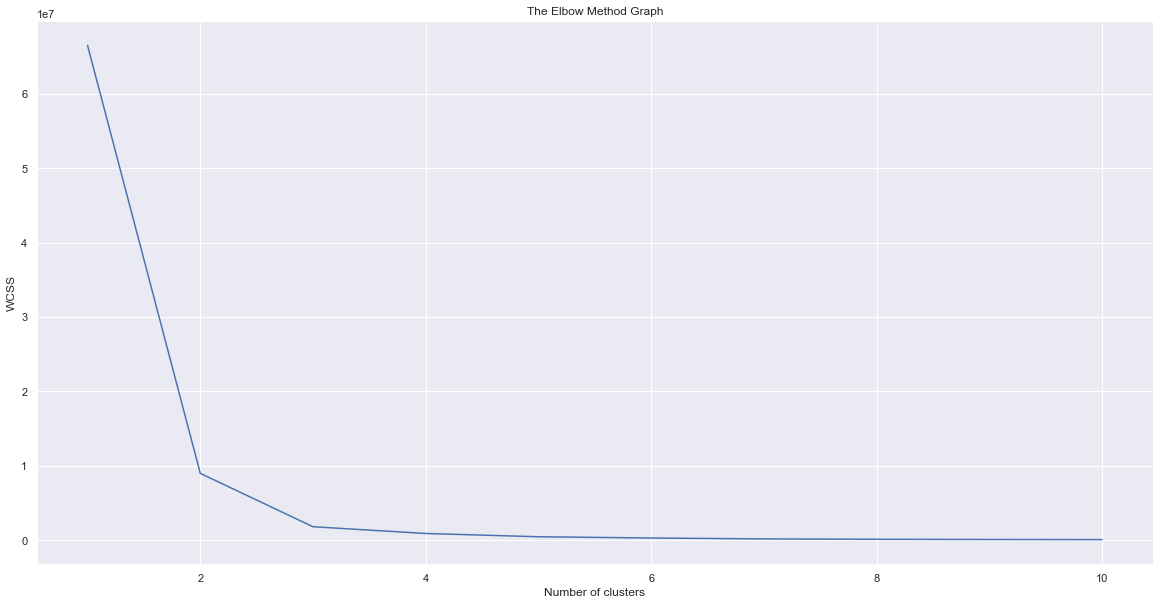

In [38]:
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

По графику можно заметить, как сильно меняется график при обновлении количества классов. Чем острее угол, тем сильнее меняется график и, соответственно, такое количество классов нам приемлемо. Однако если угол становится сильно тупым, то мы вынуждены не рассматривать то количество классов, при котором угол стал тупым. 

На графике выше мы выделили 4 кластера, с ним и продолжим работу. Давайте инициализируем метод Kmeans с 4 кластерами и обучим его:

In [39]:
model = KMeans(n_clusters=4, max_iter=300, n_init=10, random_state=45)
data_for_models['clusters'] = model.fit_predict(data_for_models.drop('id', axis=1))

C:\Users\limit\AppData\Local\Temp/ipykernel_21244/4106042549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_models['clusters'] = model.fit_predict(data_for_models.drop('id', axis=1))


Давайте посмотрим, какие классы имеют при себе наибольшее количество элементов:

In [40]:
data_for_models.clusters.value_counts()

0    53303
3     1619
2      563
1      390
Name: clusters, dtype: int64

распределение данных выглядит хорошим: у нас тут есть и преобладающий класс, и сильно малый. Однако давайте проверим как ситуация обстоит в уровне опасности дорог по каждому кластеров:

In [41]:
print("Максимальный уровень опасности дороги в кластере 0:", data_for_models[data_for_models.clusters == 0]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 1:", data_for_models[data_for_models.clusters == 1]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 2:", data_for_models[data_for_models.clusters == 2]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 3:", data_for_models[data_for_models.clusters == 3]['danger_level'].max())

Максимальный уровень опасности дороги в кластере 0: 0.024691358024691357
Максимальный уровень опасности дороги в кластере 1: 2.0039738029753846e-05
Максимальный уровень опасности дороги в кластере 2: 0.00017913276627218934
Максимальный уровень опасности дороги в кластере 3: 0.07716049382716049


Самый опасный кластер - 0, самый безопасный - 2. Давайте зададим цвета и отобразим на графике наши данные: количество инцидентов по адресу на уровень опасности дороги:

In [42]:
data_for_graphic = data_for_models.copy()

In [43]:
# centroids = model.cluster_centers_

# cen_x = [i[0] for i in centroids] 
# cen_y = [i[1] for i in centroids]

# data_for_graphic['center_x'] = data_for_graphic.clusters.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})#, 4:cen_x[4]})
# data_for_graphic['center_y'] = data_for_graphic.clusters.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})#, 4:cen_y[4]})
colors = [ 'red', 'darkgreen', 'lightgreen', 'yellow']#, '#93df20'], '#46df20']
data_for_graphic['color'] = data_for_graphic.clusters.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})#, 4:colors[4]})

# plt.scatter(data_for_models['cluster'==0, 0], data_for_models['cluster'==0, 1], s=100, c='red', label ='Cluster 1')
# plt.scatter(data_for_models['cluster'==1, 0], data_for_models['cluster'==1, 1], s=100, c='blue', label ='Cluster 2')
# plt.scatter(data_for_models['cluster'==2, 0], data_for_models['cluster'==2, 1], s=100, c='green', label ='Cluster 3')

Text(0, 0.5, 'Уровень опасности дороги')

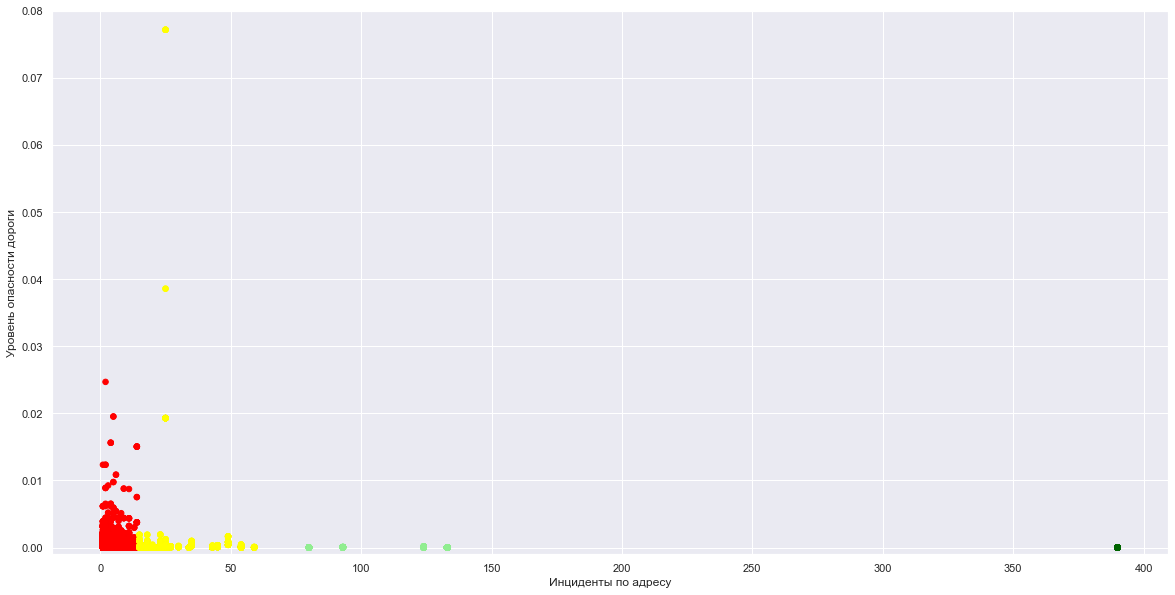

In [44]:
plt.scatter(data_for_graphic.total_incidents_address, data_for_graphic.danger_level, c=data_for_graphic.color, s=30)
plt.ylim(-0.001, 0.08)
plt.xlabel('Инциденты по адресу')
plt.ylabel('Уровень опасности дороги')

# centroids = pd.DataFrame(model.cluster_centers_, columns=data_for_models.columns)
# # Добавление столбца с номером кластера
# data_for_models['label'] = model.labels_.astype(str)
# centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']
# # Сброс индекса понадобится дальше
# data_all = pd.concat([data_for_models, centroids], ignore_index=True)

# # Построение графика
# sns.pairplot(data_all, hue='label', diag_kind='hist') 

Данные в ужасном виде: Kmeans разделил данные по количеству инцидентов на адрес, что в корне неверно - разделение данных должно было опираться на три признака, а не только на один. Давайте проверим следующий метод класстеризации -  гаусовсская кластеризация. Здесь мы также воспользуемся данными, которые строили нам Kmeans и количество кластеров то же - 4:

In [45]:
gaussian_data = data_for_models.drop('clusters', axis=1).copy()
gaussian_data.head(2)

,id,total_incidents_address,danger_level,frequency
0,2311491,1,1.284599e-08,0.000113
1,2489516,2,2.569197e-08,0.000227


In [46]:
gm = GaussianMixture(n_components=4, random_state=0).fit(gaussian_data.drop('id', axis=1))
gaussian_data['clusters'] = gm.predict(gaussian_data.drop('id', axis=1))
gaussian_data['clusters'].value_counts()

0    44577
3     9351
2     1557
1      390
Name: clusters, dtype: int64

Распределение значений по кластерам крайне интересное: у нас здесь два почти одинаковых по набору элементов кластеров и один крайне малый, что верно. Давайте проверим максимальные значения в каждом кластере:

In [47]:
print("Максимальный уровень опасности дороги в кластере 0:", gaussian_data[gaussian_data.clusters == 0]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 1:", gaussian_data[gaussian_data.clusters == 1]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 2:", gaussian_data[gaussian_data.clusters == 2]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 3:", gaussian_data[gaussian_data.clusters == 3]['danger_level'].max())

Максимальный уровень опасности дороги в кластере 0: 0.0009765625
Максимальный уровень опасности дороги в кластере 1: 2.0039738029753846e-05
Максимальный уровень опасности дороги в кластере 2: 0.0019358639845130881
Максимальный уровень опасности дороги в кластере 3: 0.07716049382716049


Самый опасный кластер - 3, самый безопасный - 1. Данные распределены в более разбросанном виде, что немного радует, давайте теперь отобразим все на графике:

In [48]:
gaussian_data_for_graphic = gaussian_data.copy()

In [49]:
colors = ['darkgreen', 'lightgreen', 'yellow', 'red']
gaussian_data_for_graphic['color'] = gaussian_data_for_graphic.clusters.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})#, 4:colors[4]})

Text(0, 0.5, 'Уровень опасности дороги')

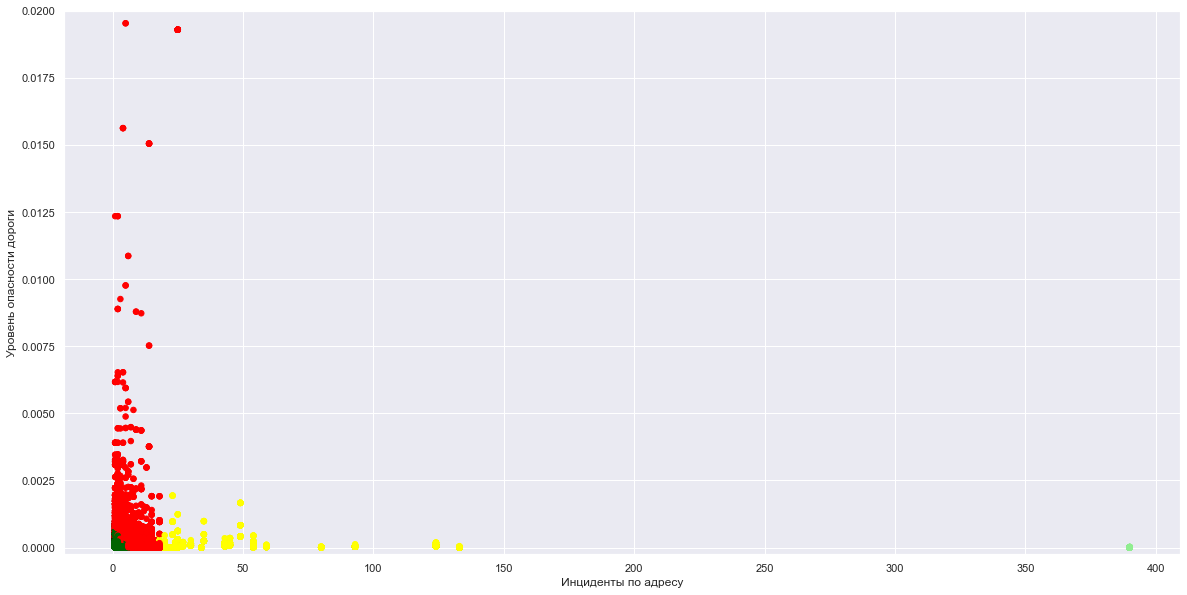

In [50]:
plt.scatter(gaussian_data_for_graphic.total_incidents_address, 
            gaussian_data_for_graphic.danger_level, 
            c=gaussian_data_for_graphic.color, s=30)
plt.ylim(-0.00025, 0.02)
plt.xlabel('Инциденты по адресу')
plt.ylabel('Уровень опасности дороги')

Распределение значений на графике отличное - все кластеры лежат аккуратно друг за другом, что говорит нам о том, что кластеризатор справился со своей целью. Те значения, которые смешиваются со значениями другого класса показывают нам о значениях в других признаках - кластеризатор составляет классы не на основе одного признака, а на основе всех.

Следующим действием будет объединение данных с итоговой выборкой, но под другой переменной:

In [51]:
total_data_clusters = total_data_ready.copy()
total_data_clusters = total_data_clusters.merge(gaussian_data_for_graphic, on=['id','total_incidents_address','danger_level','frequency'])
total_data_clusters.head()

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month,clusters,color
0,2311491,Дорожно-транспортные происшествия,2,"Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",21,10,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,938,2,5,53.342000,83.690300,8823,1,3,1.284599e-08,0.000113,9,0,darkgreen
1,2489516,"Дорожно-транспортные происшествия, ДТП и постр...",4,"Многоквартирные жилые дома, Нерегулируемый пеш...",Барнаул,"г Барнаул, ул Юрина, 241",0,16,2020-09-24 09:30:00,Легкий,0,2,Алтайский край,104,3,14,53.369248,83.699802,8823,2,3,2.569197e-08,0.000227,9,0,darkgreen
2,2565463,"Дорожно-транспортные происшествия, ДТП и постр...",4,"Многоквартирные жилые дома, Школа либо иная де...",Барнаул,"г Барнаул, тракт Павловский, 68",21,9,2021-04-20 18:55:00,Легкий,0,1,Алтайский край,1175,2,18,53.343391,83.704684,8823,1,3,1.284599e-08,0.000113,4,0,darkgreen
3,2565477,Дорожно-транспортные происшествия,4,"Жилые дома индивидуальной застройки, Нерегулир...",Барнаул,"г Барнаул, ул Совхозная, 10 а",7,9,2021-04-28 12:20:00,Легкий,0,1,Алтайский край,938,2,28,53.380807,83.690007,8823,1,3,1.284599e-08,0.000113,4,0,darkgreen
4,2565484,Дорожно-транспортные происшествия,0,"Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Советской Армии, 123",0,9,2021-04-27 21:00:00,Тяжёлый,0,1,Алтайский край,188,2,28,53.351736,83.718964,8823,2,2,5.138394e-08,0.000227,4,0,darkgreen


In [52]:
total_data_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55875 entries, 0 to 55874
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       55875 non-null  int64         
 1   tags                     55875 non-null  object        
 2   light                    55875 non-null  int32         
 3   nearby                   55875 non-null  object        
 4   region                   55875 non-null  object        
 5   address                  55875 non-null  object        
 6   weather                  55875 non-null  int32         
 7   category                 55875 non-null  int32         
 8   datetime                 55875 non-null  datetime64[ns]
 9   severity                 55875 non-null  object        
 10  dead_count               55875 non-null  int64         
 11  injured_count            55875 non-null  int64         
 12  parent_region            55875 n

In [53]:
total_data_clusters.clusters.value_counts()

0    44577
3     9351
2     1557
1      390
Name: clusters, dtype: int64

Два столбца были добавлены по своим местам - по связи столбца `id`, а это значит что у нас полностью готовая таблица для обучения моделей машинного обучения. Также количество значений в кластере осталось тем же, значит копирование данных прошло успешно.

## Создание интерактивной карты

Одной из задач заказчика была интерактивная карта, которая показала бы нам где какие дороги по уровню их опасности. Хотелось бы сразу отметить, что на локальной машине, где выполняется проект мощности ПК не позволяют отобразить уже готовую карту, однако по ходу проекта вы можете проверить ее на своем устройстве.

Для создания интерактивной карты мы воспользуемся признаками `address`, `lat`, `long` и `color`. Также вся работа будет выполнена с помощью библиотеки `folium`. Давайте создадим новую переменную для таблицы:

In [54]:
data_for_geo = total_data_clusters[['address', 'lat', 'long', 'color']]
data_for_geo.head()

,address,lat,long,color
0,"г Барнаул, тракт Павловский, 249 а",53.342000,83.690300,darkgreen
1,"г Барнаул, ул Юрина, 241",53.369248,83.699802,darkgreen
2,"г Барнаул, тракт Павловский, 68",53.343391,83.704684,darkgreen
3,"г Барнаул, ул Совхозная, 10 а",53.380807,83.690007,darkgreen
4,"г Барнаул, ул Советской Армии, 123",53.351736,83.718964,darkgreen


In [55]:
data_for_geo = data_for_geo.dropna()
data_for_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55531 entries, 0 to 55874
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   address  55531 non-null  object 
 1   lat      55531 non-null  float64
 2   long     55531 non-null  float64
 3   color    55531 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.1+ MB


Как мы помним, в столбцах `lat` и `long` были пропуски, а folium не может работать с пропусками, поэтому мы их удаляем. После удаления начнем создание интерактивной картыэ. Процесс делится на три части:
- создание обычной карты
- составление маркеров на карте 
- сохранение и отображение карты

Ниже мы создаем обычную карту:

In [56]:
map_dtp = folium.Map([55.751244,37.618423], zoom_start=10, control_scale=True)
map_dtp

Карта создана, а значит мы можем приступить к добавлению маркеров. Маркеры в нашем случае будут содержать: адресс, который отобразится при нажатии на иконку, соответствующий значению в признаке `address` и цвет иконки, соответсвующий значению в столбце `color`:

In [57]:
for index, location_info in data_for_geo.iterrows():
    folium.Marker([location_info.lat, location_info.long], 
                  popup=location_info.address,
                  icon=folium.Icon(color=location_info.color)).add_to(map_dtp)

C:\Users\limit\AppData\Local\Temp/ipykernel_21244/434673765.py:4: UserWarning: color argument of Icon should be one of: {'darkred', 'darkgreen', 'pink', 'lightblue', 'beige', 'lightred', 'white', 'lightgray', 'black', 'red', 'darkpurple', 'lightgreen', 'cadetblue', 'purple', 'blue', 'gray', 'orange', 'darkblue', 'green'}.
  icon=folium.Icon(color=location_info.color)).add_to(map_dtp)


Последний этап - сохранение карты и ее отображение (отображение отстутсвует по указанным выше причинам):

In [58]:
map_dtp.save("index.html")

Интерактивная карта создана, она отображает уровень опасности каждой дороги, которая была в датасете.

## Подбор наиболее коррелируемых признаков

Для составления моделей машинного обучения и их последующего обучения, необходимо выбрать те признаки, которые наиболее точно позволят предсказать класс опасности дороги. Именно поэтому мы рассмотрим корреляционную матрицу признаков. Возьмем те признаки, которые имеет смысл использовать для прогноза класса (регион в котором произошло ДТП, к примеру, мы брать не будем - возможны блики в данных, из-за которых мы будем получать либо неверные результаты, либо переобучение моделей):

In [59]:
features_target = total_data_clusters[['light','weather','category','dead_count','injured_count','road_conditions','participants_count','participant_categories','total_incidents_region','total_incidents_address','severity_num','danger_level','frequency','month', 'clusters']]

Корреляционная матрица требует, чтобы мы сразу указали признаки, которые являются интервальными - имеют огромное количество значений. Наименования данных признаков мы запишем в отдельной переменной и используем при создании матрицы:

C:\Users\limit\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable road_conditions is large: 1183. Are you sure this is not an interval variable? Analysis for pairs of variables including road_conditions can be slow.
  warnings.warn(


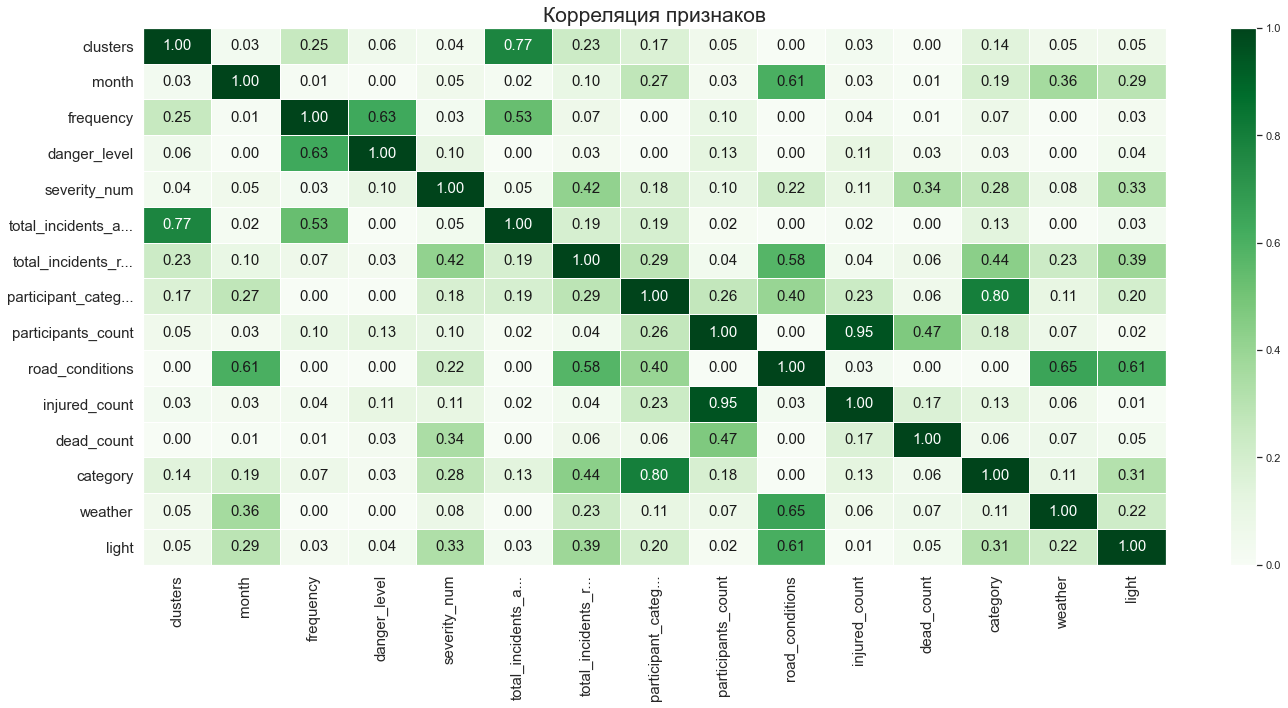

In [60]:
interval_cols = ['dead_count','injured_count','participants_count','total_incidents_region', 'total_incidents_address', 'danger_level', 'frequency']
phik_overview = features_target.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title="Корреляция признаков", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

Как можно заметить по матрице - признаки `total_incidents_addres`, `danger_level` и `frequency` больше всего коррелируют к нашим классам - их и возьмем в обучение модели. Однако стоит отметить один важный момент - `frequency` это деление `total_incidents_addres` на `total_incidents_region`, то есть связь между ними очень сильная, что может повлечь за собой проблему бликов и подглядыванию модели в ответы, поэтому данный признак мы не можем брать в обучение.

В итоге у нас два признака: `total_incidents_addres` и `danger_level`, которые мы будем использовать при прогнозе класса опасности дорог.

## Создание выборок

Перед обучением создадим выборки, на который мы и будем обучать, и проверять качество моделей в целом. 

Первым делом мы разделим данные на обучающую и валидационную выборки с процентным соотношением 80/20:

In [61]:
most_corr_col = ['total_incidents_address', 'danger_level']#, 'frequency']
features_train, features_valid, target_train, target_valid = train_test_split(features_target[most_corr_col], features_target['clusters'], test_size=0.20, random_state=69)
print(features_train.shape, features_valid.shape)

(44700, 2) (11175, 2)


Далее стоит учесть, что логистическая регрессия чувствительна к разреженным данным, то есть к большим диапазонам в данных. Поэтому мы масштабируем признак `total_incidents_address` как в обучающей, так и в валидационной выборке. 

In [62]:
scaler = StandardScaler()
scaler.fit(features_train[['total_incidents_address']])

features_train['total_incidents_address'] = scaler.transform(features_train[['total_incidents_address']])
features_valid['total_incidents_address'] = scaler.transform(features_valid[['total_incidents_address']])

features_train.head()

,total_incidents_address,danger_level
2223,11.178185,5.009935e-06
48602,-0.180104,2.381859e-07
51808,-0.180104,1.436369e-04
43277,-0.150906,6.147110e-08
30067,-0.180104,2.500000e-05


Также стоит отметить, что в наших данных была проблема размерности классов: классы 1 и 0 содержат крайне много значений, а вот 2 и, тем более, 3 совсем чуть-чуть. Давайте отобразим на графике их размеры:

<AxesSubplot:title={'center':'Размерность классов'}, ylabel='Frequency'>

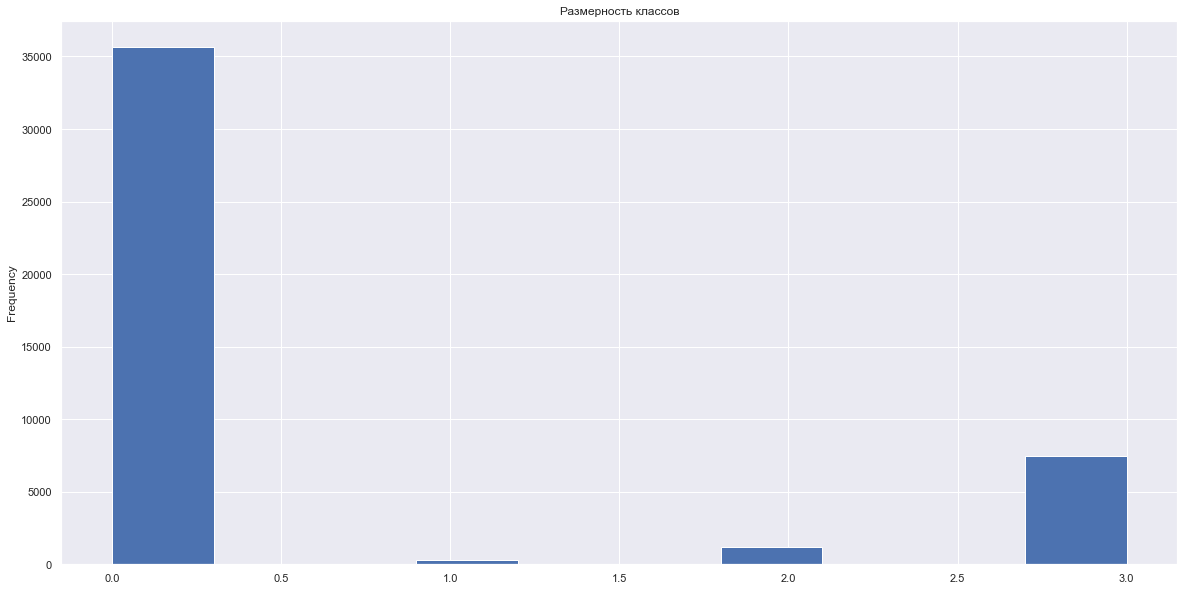

In [63]:
target_train.plot(kind='hist', title='Размерность классов')

Что и требовалось доказать - класс 3 вообще не видно, оно и верно, во всем датасете их всего 101 штука. Для решения данной проблемы в моделях мы добавим аргумент баланса классов на `balanced`

## Обучение моделей

Последний этап - обучение и выявление лучшей модели. Для обучения мы выбрали 3 алгоритма: градиентный бустинг, логистическая регрессия и случайный лес.

Первым делом инициализируем их (для решения проблемы баланса добавим аргумент `class_weight`):

In [64]:
model_ligtgb = LGBMClassifier(random_state=69, class_weight='balanced')
model_linear = LogisticRegression(solver="newton-cg", class_weight='balanced')
model_forest = RandomForestClassifier(random_state=49, class_weight='balanced')

Далее создадим функцию, которая будет подбирать наилучшую модель проверяя их гиперпараметры, с помощью:
- кроссвалидации
- обучение разных моделей по определенным гиперпараметрам с метрикой `roc_auc`
- среди обученных моделей выбираем лучшую и смотрим качество прогнозов по метрику `accuracy`

In [65]:
def select_best_model(params, model, x_train, x_test, y_train, y_test):
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    grid = RandomizedSearchCV(model, params, 
                              n_iter=1, scoring='roc_auc_ovr', cv=cv, random_state=69)
    grid.fit(x_train, y_train)
    best_grid = grid.best_estimator_
    
    tr_pred, te_pred = (
        accuracy_score(y_train, best_grid.predict(x_train)), 
        accuracy_score(y_test, best_grid.predict(x_test))
    )
    
    return tr_pred, te_pred, best_grid

Далее запускаем функцию для трех моделей и смотрим на лучший результат:

In [66]:
random_grid_lgb = {
    'n_estimators': [i for i in range(30, 150, 5)],
    'max_depth': [i for i in range(5, 15)]
    }

lgb_train_score, lgb_valid_score, lgb_best_model = select_best_model(
    random_grid_lgb, 
    model_ligtgb, 
    features_train, 
    features_valid, 
    target_train, 
    target_valid
)
print(f'Result on train: {lgb_train_score}, and valid {lgb_valid_score}\n on model {lgb_best_model}')

Result on train: 0.981834451901566, and valid 0.9831767337807606
 on model LGBMClassifier(class_weight='balanced', max_depth=7, n_estimators=60,
               random_state=69)


Градиентный бустинг дал 97.6 процентов качества на своей лучшей модели

In [67]:
random_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
    }

lr_train_score, lr_valid_score, linear_best_model = select_best_model(
    random_grid_lr, 
    model_linear, 
    features_train, 
    features_valid, 
    target_train, 
    target_valid
)
print(f'Result on train: {lr_train_score}, and valid {lr_valid_score}\n on model {linear_best_model}')

Result on train: 0.9208501118568233, and valid 0.9221476510067114
 on model LogisticRegression(C=0.01, class_weight='balanced', solver='newton-cg')


Логистическая регрессия дала 80 процентов на своей лучшей модели

In [68]:
random_grid_forest = {
    'n_estimators': [i for i in range(30, 150, 5)],
    'max_depth': [i for i in range(5, 15)],
    'min_samples_leaf' : [i for i in range(1, 15)]
    }

forest_train_score, forest_valid_score, forest_best_model = select_best_model(
    random_grid_forest, 
    model_forest, 
    features_train, 
    features_valid, 
    target_train, 
    target_valid
)
print(f'Result on train: {forest_train_score}, and valid {forest_valid_score}\n on model {forest_best_model}')

Result on train: 0.9926845637583893, and valid 0.992751677852349
 on model RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=5, n_estimators=60, random_state=49)


Случайный лес дал 99 процентов качества.

Их трех моделей лучше всего себя показал случайный лес со своими 99 процентами, что крайней странно, также как и у градиентного бустинга с 97 процентами. Возможно где-то произошел блик данных, но сейчас трудно сказать, где именно он произошел. Поэтому для заказчика лучшим вариантом будет логистическая регрессия с их 80 процентами качества.

## Вывод

В ходе всей работы мы провели много действий, которые привели нас к заключительной части - выводу. Хотелось бы вспомнить, что было сделано:
- загружены данные с официального сайта dtp-stat.ru
- данные были предобработаны: извлечены со словарей и списков, заменены типы данных и проверены на уникальность аварий
- введены новые признаки, которые дали нам лучшее представление о самих ДТП
- визуализированы зависимости данных друг к другу
- выполнена кластеризация данных, с применением двух моделей кластеризации: Kmeans и GaussianMixture, в результате чего мы получили четыре класса опасности дорог 
- составлена интерактивная карта по тем данным, которые были в нашей выборке после парсинга
- найдены наиболее коррелируемые данные к нашим кластерам
- обучены три модели машинного обучения: LGBMClassifier, LogisticRegression и RandomForestClassifier, после которого были получены результаты и выявлена лучшая модель - LogisticRegression

В заключении нужно сказать, что модель логистической регрессии выбрана только из-за того, что в ней не было бликов данных, которые присутствовали в случайном лесе и градиентном бустинге.